<a href="https://colab.research.google.com/github/DaisyXinyiHe/stock_prediction/blob/main/finance_news_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mount drive from google drive if needed
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/stock_prediction

/content/drive/MyDrive/Colab Notebooks/stock_prediction


In [ ]:
%pip install flair
%pip install gensim
%pip install pyvis

     |████████████████████████████████| 322 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 32.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.4 MB 34.2 MB/s 
     |████████████████████████████████| 48 kB 5.3 MB/s 
     |████████████████████████████████| 788 kB 47.1 MB/s 
     |████████████████████████████████| 981 kB 37.5 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 19.7 MB 1.2 MB/s 
     |████████████████████████████████| 61 kB 508 kB/s 
     |████████████████████████████████| 62 kB 864 kB/s 
     |████████████████████████████████| 895 kB 25.1 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 3.3 MB 37.2 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=7de66462f30c189c74f1d75ca09aa8c68fb807caf36aa8

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import emodict ## This is a emoji dictionary downloaded from github and stored in folders
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
from itertools import combinations
import networkx as nx
from pyvis.network import Network
import seaborn as sn
## Import emoji libraries
EMOTICONS = emodict.EMOTICONS_EMO
UNICODE_EMO = emodict.UNICODE_EMOJI

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Stocks

In [ ]:
# news = pd.read_csv('./archive/Combined_News_DJIA.csv')
news = pd.read_csv('./archive/RedditNews.csv')
stocks = pd.read_csv('./archive/upload_DJIA_table.csv')

In [ ]:
news

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."


In [ ]:
stocks

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234
...,...,...,...,...,...,...,...
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609


In [ ]:
price_change_percentage = 100 *stocks.Close.pct_change()#.dropna()
stocks['price_change'] = price_change_percentage

In [ ]:
## Tweet cleaning functions

## Change all tweets to lowercase
def lower_case(tweet):
  return tweet.lower()

## Remove punctuation
def remove_punctuation(tweet):
  PUNCT_TO_REMOVE = string.punctuation+'’'+'「'+'」'
  return tweet.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

## Filter stop words
def filter_stopwords(tweet):
  filtered = ''
  stop_words = stopwords.words('english')
  stop_words.append('im')
  stop_words = set(stop_words)
  word_tokens = word_tokenize(tweet)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  filtered = ' '
  filtered =filtered.join(filtered_sentence)
  return filtered


## Remove unnecessary symbols
def clean(tweet):
  # tweet = re.sub(r'@[A-Za-z0-9]','', tweet) # remove @mention
  # tweet = re.sub(r'@','', tweet)
  # tweet = re.sub(r'#','', tweet) # remove hastag symbol
  # tweet = re.sub(r'https?:\/\/\S+','', tweet) # remove hyperlink
  # tweet = re.sub(r"b'[\s]+",'', tweet) # remove 'RT'
  tweet = remove_punctuation(tweet)
  tweet = filter_stopwords(tweet)



  return tweet




## replace emoji and emoticons to words
# def convert_emoticons(tweet):
#   for emot in EMOTICONS:
#     if emot in tweet:
#       tweet = tweet.replace(emot, EMOTICONS[emot])
#   return tweet

def convert_emoji(tweet):
  for emo in UNICODE_EMO:
    if emo in tweet:
      tweet = tweet.replace(emo, UNICODE_EMO[emo])
    tweet = tweet.lower()
    tweet = tweet.replace(':', '')
    # tweet = tweet.replace('_', ' ')
  return tweet

## Take away the keywords for search in tweets
def take_away_keyword(tweet):
  for k in search_word:
    if k in tweet:
      tweet = tweet.replace(k, '')
  return tweet

## Connect keywords as one word
def connect_keyword(tweet, keyword):
  keyword_connected = keyword.replace(' ', '_')
  if keyword in tweet:
    tweet = tweet.replace(keyword, keyword_connected)
  return tweet
    



In [ ]:
news['clean_news'] = news['News'].apply(lower_case)
news['clean_news'] = news['News'].apply(clean)

# Flair: Preserved punctuation and stop word

In [ ]:
classifier = TextClassifier.load('en-sentiment')

## Test model
sentence = Sentence('Flair is pretty neat!')
classifier.predict(sentence)
# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2021-12-20 18:14:26,673 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpqxtnu3vu


100%|██████████| 265512723/265512723 [00:10<00:00, 24448127.93B/s]

2021-12-20 18:14:37,904 copying /tmp/tmpqxtnu3vu to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-20 18:14:38,867 removing temp file /tmp/tmpqxtnu3vu
2021-12-20 18:14:38,906 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sentence above is:  [POSITIVE (0.9997)]


In [ ]:
sentences = [Sentence(s) for s in news['clean_news']]

In [ ]:
classifier.predict(sentences)


In [ ]:
sent = str(sentences[0].labels[0])
num = float(re.findall("\d+\.\d+", sent)[0])
lab = " ".join(re.findall("[a-zA-Z]+", sent))
print(num, lab)

# [float(s) for s in sent.split() if s.isdigit()]

0.9869 NEGATIVE


In [ ]:
sent_labels=[]
sent_conf = []
for s in range(0,len(sentences)):
  if sentences[s]:
    sent = str(sentences[s].labels[0])
    sent_conf.append(float(re.findall("\d+\.\d+", sent)[0]))
    sent_labels.append(" ".join(re.findall("[a-zA-Z]+", sent)))

In [ ]:
news['sentiment'] = sent_labels
news['sentiment_confidence'] =sent_conf


In [ ]:
news['sentiment_confidence'] = news['sentiment_confidence'].astype(float)

In [ ]:
news = news.loc[news['sentiment_confidence']>0.50]

In [ ]:
news.groupby('sentiment').size()

sentiment
NEGATIVE    60965
POSITIVE    12643
dtype: int64

# Comparing: Textblob and VADER

In [ ]:
news['News'] = news['News'].apply(clean)

In [ ]:
from textblob import TextBlob
## Get subjectivity
def getsubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity
## Get polarity
def getpolarity(tweet):
  return TextBlob(tweet).sentiment.polarity

In [ ]:
news['subjectivity'] = news['News'].apply(getsubjectivity)
news['polarity'] = news['News'].apply(getpolarity)
date_sentiment_textblob = news.groupby(['Date']).mean()

In [ ]:
## Sentiment analysis
def sentiment(polarity):
  if polarity > 0:
    sentiment = 'positive'
  elif polarity < 0:
    sentiment = 'negative'
  else:
    sentiment = 'neutral'
  return sentiment
news['sentiment_TB'] = news['polarity'].apply(sentiment)

In [ ]:
sentence = news['News'].iloc[72451]
print(sentence)
print(TextBlob(sentence).sentiment.polarity)

bus war drugs fail afghanistan
-0.5


## VADER

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
a = 'president france says brexit donald trump'
sid.polarity_scores(a)



{'compound': -0.8126, 'neg': 0.712, 'neu': 0.288, 'pos': 0.0}

## Sentiment Plot

In [ ]:
# news = pd.read_csv('news_sentiment.csv')

In [ ]:
from datetime import datetime
news['Date'] = news.apply(lambda x:datetime.strptime(x['Date'], '%Y-%m-%d'),axis = 1)
stocks['Date'] = stocks.apply(lambda x:datetime.strptime(x['Date'], '%Y-%m-%d'),axis = 1)

In [ ]:
def label_pos_sent(sentiment):
  if sentiment == 'POSITIVE':
    label = 1
  else:
    label = 0
  return label

In [ ]:
news['positive'] = news['sentiment'].apply(label_pos_sent)

In [ ]:
date_sentiment = news.groupby(['Date'])['positive'].mean()
# date_sentiment = pd.DataFrame(date_sentiment)

In [ ]:
stocks = stocks.merge(date_sentiment, left_on='Date', right_on=date_sentiment.index)

In [ ]:
# stocks.to_csv('stocks_wsentiment.csv', index = False)

In [ ]:
news['News'].loc[(news['sentiment'] == 'POSITIVE')].sample(n=10)

7237     tourists interrupt endangered turtle reproduct...
47619        australian navy rescues hostages from pirates
28568    a x-47b drone took off from the deck of an ame...
44254    libyan activist freed from prison after 14 yea...
745      italian man suffers brain damage and now speak...
27120    saudi, uae and kuwait provide $12 bil to egypt...
46047    photos: riots, fire, destruction after vancouv...
33723    seeking a better life and a future for their c...
39077    germanys $263 billion shift to renewable energ...
68644          b'blix may testify against iraq war makers'
Name: News, dtype: object

In [ ]:
# all_tweets['tweet'].loc[7843][0:80]
news['News'].loc[46047]

"photos: riots, fire, destruction after vancouver's loss"

In [ ]:
# news = pd.read_csv('news_sentiment.csv')

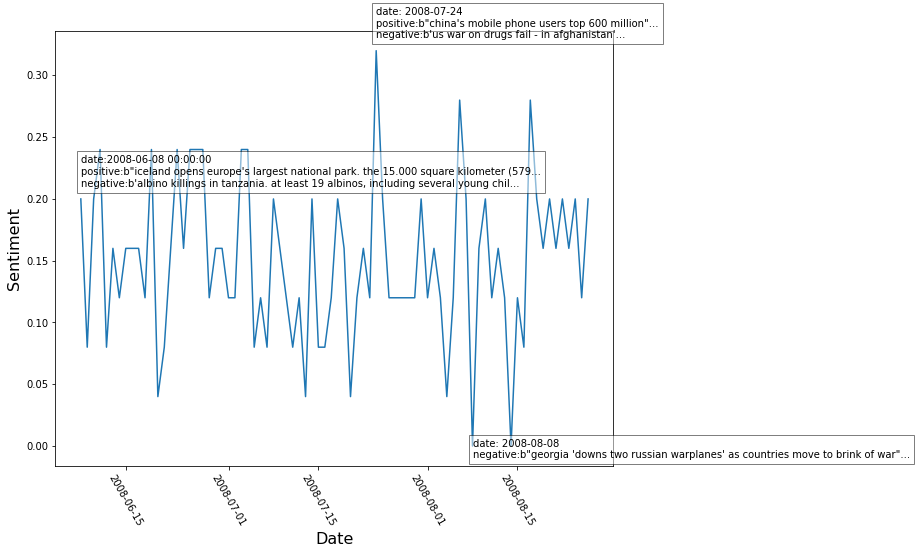

In [ ]:
plt.figure(figsize = (10,8))
# plt.plot(date_sentiment.index, date_sentiment.values)
plt.plot(date_sentiment.index[0:80], date_sentiment.values[0:80])
plt.xticks(rotation = 300)


textstr1 = '\n'.join((
    r'date:'+ str(date_sentiment.index[0]),
    r'positive:'+news['News'].loc[73595][0:80]+'...',
    r'negative:'+news['News'].loc[73586][0:80]+'...'))
textstr2 = '\n'.join((
    r'date: 2008-07-24',
    r'positive:'+news['News'].loc[72448][0:80]+'...',
    r'negative:'+news['News'].loc[72450][0:80]+'...'))
textstr3 = '\n'.join((
    r'date: 2008-08-08',
    r'negative:'+news['News'].loc[72057][0:80]+'...'))


plt.text(x = news['Date'].loc[73586], y=date_sentiment.loc[news['Date'].loc[73586]]+0.01, s = textstr1, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = date_sentiment.index[46], y=date_sentiment.values[46]+0.01, s = textstr2, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = news['Date'].loc[72057], y=date_sentiment.loc[news['Date'].loc[72057]]-0.01, s = textstr3, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)



plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sentiment', fontsize = 16)

plt.show()

Fixed effect model of sentiment on stock close price  in R

# Crypto

In [ ]:
def get_date(datetime_str):
  date = datetime_str.split(' ')
  date = date[0]
  return date

In [ ]:
crypto_news = pd.read_csv('./cointelegraph_news/cointelegraph_news_head.csv')
crypto_btc = pd.read_csv('./crypto_price/coin_Bitcoin.csv')
crypto_eth = pd.read_csv('./crypto_price/coin_Ethereum.csv')
crypto_ltc = pd.read_csv('./crypto_price/coin_Litecoin.csv')

In [ ]:
crypto_btc['date'] = crypto_btc['Date'].apply(get_date)
crypto_eth['date'] = crypto_eth['Date'].apply(get_date)
crypto_ltc['date'] = crypto_ltc['Date'].apply(get_date)
crypto_news['date'] = crypto_news['published_date'].apply(get_date)

In [ ]:
crypto_news['date'] = crypto_news.apply(lambda x:datetime.strptime(x['date'],'%Y-%m-%d'),axis = 1)
crypto_btc['date'] = crypto_btc.apply(lambda x:datetime.strptime(x['date'],'%Y-%m-%d'),axis = 1)
crypto_eth['date'] = crypto_eth.apply(lambda x:datetime.strptime(x['date'],'%Y-%m-%d'),axis = 1)
crypto_ltc['date'] = crypto_ltc.apply(lambda x:datetime.strptime(x['date'],'%Y-%m-%d'),axis = 1)

Mimicing an ETF by taking the mean of major crypto price 

In [ ]:
crypto_price = pd.concat([crypto_btc,crypto_eth, crypto_ltc])

In [ ]:
crypto_price = crypto_price.groupby(['date']).mean()

In [ ]:
crypto_news['title'] = crypto_news['title'].apply(lower_case)
crypto_news['title'] = crypto_news['title'].apply(clean)

In [ ]:
classifier = TextClassifier.load('en-sentiment')

## Test model
sentence = Sentence('Flair is pretty neat!')
classifier.predict(sentence)
# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2021-12-21 04:03:17,542 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpq_kktzro


100%|██████████| 265512723/265512723 [00:28<00:00, 9233581.60B/s] 

2021-12-21 04:03:47,149 copying /tmp/tmpq_kktzro to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-21 04:03:48,161 removing temp file /tmp/tmpq_kktzro
2021-12-21 04:03:48,225 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sentence above is:  [POSITIVE (0.9997)]


In [ ]:
sentences = [Sentence(s) for s in crypto_news['title']]

In [ ]:
classifier.predict(sentences)


In [ ]:
sent = str(sentences[0].labels[0])
num = float(re.findall("\d+\.\d+", sent)[0])
lab = " ".join(re.findall("[a-zA-Z]+", sent))
print(num, lab)

# [float(s) for s in sent.split() if s.isdigit()]

0.8273 NEGATIVE


In [ ]:
sent_labels=[]
sent_conf = []
for s in range(0,len(sentences)):
  if sentences[s]:
    sent = str(sentences[s].labels[0])
    sent_conf.append(float(re.findall("\d+\.\d+", sent)[0]))
    sent_labels.append(" ".join(re.findall("[a-zA-Z]+", sent)))

In [ ]:
crypto_news['sentiment'] = sent_labels
crypto_news['sentiment_confidence'] =sent_conf


In [ ]:
crypto_news['sentiment_confidence'] = crypto_news['sentiment_confidence'].astype(float)

In [ ]:
crypto_news = crypto_news.loc[crypto_news['sentiment_confidence']>0.50]

In [ ]:
crypto_news.groupby('sentiment').size()

sentiment
NEGATIVE    14810
POSITIVE    10659
dtype: int64

In [ ]:
crypto_news['positive'] = crypto_news['sentiment'].apply(label_pos_sent)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
crypto_news_sentiment = crypto_news.groupby(['date'])['positive'].mean()
# date_sentiment = pd.DataFrame(date_sentiment)

In [ ]:
crypto_price = crypto_price.merge(crypto_news_sentiment,left_on='date', right_on='date')
returns = 100 *stocks.Close.pct_change()#.dropna()
crypto_price['returns'] = returns
# crypto_price['return'] = crypto_price['Close'] - crypto_price['Open']
crypto_price

,SNo,High,Low,Open,Close,Volume,Marketcap,positive_x,positive_y,returns
date,,,,,,,,,,
2013-08-01,95,55.502840,52.932236,54.543554,53.454960,0.000000e+00,6.266395e+08,1.000000,1.000000,NaN
2013-08-04,98,54.497633,53.230076,53.980508,54.076604,0.000000e+00,6.350428e+08,1.000000,1.000000,NaN
2013-08-05,99,55.402093,53.910600,54.059536,54.525381,0.000000e+00,6.397416e+08,0.500000,0.500000,NaN
2013-08-07,101,54.785805,54.724420,54.785805,54.752870,0.000000e+00,6.422821e+08,1.000000,1.000000,NaN
2013-08-08,102,54.779225,51.962856,54.751810,52.852390,0.000000e+00,6.208126e+08,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-04-01,2253,2262.529719,2123.183464,2203.405409,2260.597211,1.870233e+10,4.613538e+10,0.538462,0.538462,NaN
2020-04-02,2254,2425.560020,2256.968159,2260.623974,2325.175970,2.232315e+10,4.752596e+10,0.444444,0.444444,NaN
2020-04-03,2255,2397.068355,2284.213317,2326.464891,2305.279279,1.854793e+10,4.717570e+10,0.472727,0.472727,NaN


In [ ]:
# crypto_price.to_csv('crypto_wsentiment.csv', index = False)
crypto_news = pd.read_csv('crypto_wsentiment.csv')